# B. State purification with qubit-mediated measurement

In [1]:
# ruff: noqa
import os

os.sys.path.append("..")
from feedback_grape.fgrape import optimize_pulse_with_feedback
import jax.numpy as jnp

## The cavity is initially in a  mixed state --> Goal is to purify the state

We are trying to maximize the property determined by $tr (\rho_{\text{cav}}^2)$ which is the purity

In the following, we consider an adaptive measurement
scheme, demonstrated in a series of experiments on Rydberg atoms interacting
with microwave cavities. In this scheme, the
cavity is coupled to an ancilla qubit, which can then be
read out to update our knowledge of the quantum state of
the cavity.

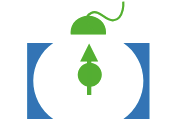

In [2]:
# initial state is a thermal state
n_average = 2
N_cavity = 30
# natural logarithm
beta = jnp.log((1 / n_average) + 1)
diags = jnp.exp(-beta * jnp.arange(N_cavity))
normalized_diags = diags / jnp.sum(diags, axis=0)
rho_cav = jnp.diag(normalized_diags)

### Now the thing is here, we don't need a rho_final because the purity or the reward that we want to maximize is $tr (\rho_{\text{cav}}^2)$.
Unlike fidelity expressions which wants to find how close to states are

## Next Step is to construct our POVM

In [3]:
from feedback_grape.utils.operators import cosm, sinm

In [30]:
from feedback_grape.utils.operators import create, destroy
import jax


def povm_measure_operator(measurement_outcome, gamma, delta):
    """
    POVM for the measurement of the cavity state.
    returns Mm ( NOT the POVM element Em = Mm_dag @ Mm ), given measurement_outcome m, gamma and delta
    """
    # TODO: see if there is a better way other than flattening
    number_operator = create(N_cavity) @ destroy(N_cavity)
    angle = (gamma * number_operator) + delta / 2
    return jnp.where(
        measurement_outcome == 1,
        cosm(angle),
        sinm(angle),
    )

In [41]:
# TODO: Have a default NN and then give user the ability to supply a model or a function
# With log p terms: 0.0.9984141684258416
# Without log p terms: 0.999796307373522
# Answer: why does RNN outputs two the same, then two the same, then two the same and so on? -> calculate during forward proagation then again during back_propagation
from feedback_grape.fgrape_helpers import RNN
initial_params = {"POVM": [0.1, -3 * jnp.pi / 2]}
result = optimize_pulse_with_feedback(
    U_0=rho_cav,
    C_target=None,
    parameterized_gates=[povm_measure_operator],
    measurement_indices=[0],
    initial_params=initial_params,
    num_time_steps=5,
    mode="nn",
    goal="purity",
    optimizer="adam",
    max_iter=1000,
    convergence_threshold=1e-20,
    learning_rate=0.001,
    type="density",
    batch_size=100,
    RNN=RNN,
)

Iteration 0, Loss: 0.085835
Iteration 10, Loss: 0.260577
Iteration 20, Loss: 0.486958
Iteration 30, Loss: 0.624089
Iteration 40, Loss: 0.709190
Iteration 50, Loss: 0.627236
Iteration 60, Loss: 0.724332
Iteration 70, Loss: 0.617487
Iteration 80, Loss: 0.659301
Iteration 90, Loss: 0.701691
Iteration 100, Loss: 0.729965
Iteration 110, Loss: 0.704535
Iteration 120, Loss: 0.639255
Iteration 130, Loss: 0.658940
Iteration 140, Loss: 0.638138
Iteration 150, Loss: 0.590883
Iteration 160, Loss: 0.639298
Iteration 170, Loss: 0.658411
Iteration 180, Loss: 0.671866
Iteration 190, Loss: 0.630372
Iteration 200, Loss: 0.730813
Iteration 210, Loss: 0.716627
Iteration 220, Loss: 0.688057
Iteration 230, Loss: 0.606693
Iteration 240, Loss: 0.729876
Iteration 250, Loss: 0.682649
Iteration 260, Loss: 0.689747
Iteration 270, Loss: 0.661748
Iteration 280, Loss: 0.637975
Iteration 290, Loss: 0.666917
Iteration 300, Loss: 0.680776
Iteration 310, Loss: 0.741342
Iteration 320, Loss: 0.810959
Iteration 330, Loss: 

In [42]:
result

FgResult(optimized_rnn_parameters={'params': {'Dense_0': {'bias': Array([-0.01803348, -0.01336229], dtype=float32), 'kernel': Array([[-0.30761436,  0.149836  ],
       [-0.27680466, -0.1330039 ],
       [ 0.20586237,  0.20060013],
       [ 0.23616235, -0.06471986],
       [ 0.06087753,  0.13914198],
       [-0.36223564,  0.20469648],
       [-0.16699089,  0.14375573],
       [ 0.25733152, -0.11921961],
       [-0.2976678 , -0.21190096],
       [-0.21030328,  0.02020856],
       [-0.10432126, -0.1185068 ],
       [-0.36823714, -0.1153165 ],
       [-0.22578688, -0.12524557],
       [ 0.09988184, -0.10155298],
       [ 0.24998343,  0.22666705],
       [ 0.3417641 , -0.29857668],
       [ 0.14908588,  0.26274538],
       [ 0.20777655, -0.13582298],
       [-0.00229268, -0.16103105],
       [ 0.17593905,  0.03328304],
       [ 0.15110293, -0.08876306],
       [-0.00095644,  0.16075961],
       [ 0.0991935 , -0.01130573],
       [ 0.07083808, -0.2128105 ],
       [ 0.04734594, -0.26128185],

In [43]:
print(result.final_fidelity)

None


In [44]:
print(result.final_state)

[[[ 5.96513184e-02+0.j -2.16126981e-02+0.j -1.38694977e-01+0.j ...
   -8.72396980e-04+0.j -3.80396968e-03+0.j -5.82377024e-03+0.j]
  [-2.16126981e-02+0.j  1.78596253e-01+0.j -2.10761943e-01+0.j ...
   -1.82315590e-03+0.j  9.38339957e-05+0.j  1.55493383e-03+0.j]
  [-1.38694977e-01+0.j -2.10761943e-01+0.j  7.23091135e-01+0.j ...
    5.28242499e-03+0.j  1.07828982e-02+0.j  1.43596930e-02+0.j]
  ...
  [-8.72396980e-04+0.j -1.82315590e-03+0.j  5.28242499e-03+0.j ...
    7.87580314e-05+0.j -4.24994789e-06+0.j -6.96907947e-05+0.j]
  [-3.80396968e-03+0.j  9.38339957e-05+0.j  1.07828982e-02+0.j ...
   -4.24994789e-06+0.j  4.04301539e-04+0.j  6.95340316e-04+0.j]
  [-5.82377024e-03+0.j  1.55493383e-03+0.j  1.43596930e-02+0.j ...
   -6.96907947e-05+0.j  6.95340316e-04+0.j  1.25139790e-03+0.j]]

 [[ 1.71328925e-03+0.j -4.04878565e-02+0.j -1.43509408e-03+0.j ...
    1.28431836e-04+0.j  2.42410336e-04+0.j -2.97780472e-04+0.j]
  [-4.04878565e-02+0.j  9.60305151e-01+0.j  3.41509221e-02+0.j ...
   -3.35

In [45]:
print(result.final_purity)

0.7345904762541271


In [46]:
from feedback_grape.utils.purity import purity
print("initial purity:", purity(rho=rho_cav))
for i, state in enumerate(result.final_state):
    print(f"Purity of state {i}:", purity(rho=state))


initial purity: 0.20000208604889932
Purity of state 0: 0.7298610593758967
Purity of state 1: 0.9340300524575604
Purity of state 2: 0.9711023807200189
Purity of state 3: 0.9711023807200189
Purity of state 4: 0.6076894195616357
Purity of state 5: 0.7298610593758967
Purity of state 6: 0.7298610593758967
Purity of state 7: 0.6957460697572541
Purity of state 8: 0.9711023807200189
Purity of state 9: 0.7298610593758967
Purity of state 10: 0.9340300524575604
Purity of state 11: 0.6915975700278639
Purity of state 12: 0.9711023807200189
Purity of state 13: 0.4477031978790358
Purity of state 14: 0.2626001942555651
Purity of state 15: 0.9340300524575604
Purity of state 16: 0.29223131253223816
Purity of state 17: 0.38734283858496543
Purity of state 18: 0.9711023807200189
Purity of state 19: 0.7298610593758967
Purity of state 20: 0.9340300524575604
Purity of state 21: 0.9711023807200189
Purity of state 22: 0.2626001942555651
Purity of state 23: 0.9711023807200189
Purity of state 24: 0.60768941956163

In [47]:
result.returned_params

[[Array([[ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
 

In [48]:
print(jax.random.PRNGKey(9))
time_step_keys = jax.random.split(jax.random.PRNGKey(9), 5)
print(time_step_keys)
for key in time_step_keys:
    print(jax.random.uniform(key))

[0 9]
[[2822284597 2722679661]
 [ 143080583 4281670255]
 [2676565412 4109519897]
 [1877436067 1979300842]
 [3339921199 4267639851]]
0.16232149317805766
0.07829857808883056
0.8422083576204116
0.23698051656885277
0.33005660981143814


In [49]:
from feedback_grape.fgrape import povm
import random

time_steps = 5

rho = rho_cav
print("initial purity:", purity(rho=rho))

rand_num = random.randint(1, 50)

time_step_keys = jax.random.split(jax.random.PRNGKey(rand_num), time_steps)
for i in range(time_steps):
    params = result.returned_params[i][0]
    print(f"params for time step {i}:", params[0])
    rho, _, _ = povm(rho, povm_measure_operator, params[0], time_step_keys[i])
    print(f"purity of rho after time step {i}", purity(rho=rho))
final_rho_cav = rho

initial purity: 0.20000208604889932
params for time step 0: [ 0.1        -4.71238898]
purity of rho after time step 0 0.22906440620511653
params for time step 1: [-0.19138208  0.01347375]
purity of rho after time step 1 0.29294091653202653
params for time step 2: [-0.68481317  0.06103043]
purity of rho after time step 2 0.47549297149401604
params for time step 3: [-1.06188408  0.15269566]
purity of rho after time step 3 0.701669307946199
params for time step 4: [-0.83687423  0.30339883]
purity of rho after time step 4 0.5279654128215544


In [40]:
from feedback_grape.utils.povm import (
    _probability_of_a_measurement_outcome_given_a_certain_state,
)

variables = jnp.array([0.1, -3 * jnp.pi / 2])
# variables_2 = {
#     "gamma": 0.1,
#     "delta": -3 * jnp.pi / 2,
# }
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, -1, povm_measure_operator, variables
    )
)
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, 1, povm_measure_operator, variables
    )
)

0.0973540364721641
0.9026459635278362


### Check stash for replacement of dict implementation

In [15]:
print("Final state after application of amplitudes:", final_rho_cav)

Final state after application of amplitudes: [[ 6.88322227e-03+0.j  6.47490762e-02+0.j  7.42744503e-03+0.j
   2.48127615e-03+0.j -2.01436133e-03+0.j -2.31671929e-03+0.j
  -2.34628081e-03+0.j -3.07076536e-03+0.j -2.35075712e-03+0.j
  -3.50670676e-04+0.j -1.55345244e-03+0.j -5.91070053e-04+0.j
  -2.22766070e-04+0.j  5.17792432e-04+0.j  6.39644821e-04+0.j
  -2.87394080e-04+0.j -7.35756915e-04+0.j -9.14741819e-04+0.j
  -1.25059643e-03+0.j -1.30159489e-03+0.j -9.64154678e-04+0.j
   8.66089190e-04+0.j -4.70036279e-04+0.j -1.12544079e-04+0.j
   7.09284659e-04+0.j -2.53118886e-04+0.j  3.54295668e-03+0.j
  -7.03344410e-04+0.j -8.32304999e-04+0.j -1.48641865e-04+0.j]
 [ 6.47490762e-02+0.j  6.51024823e-01+0.j  2.62296032e-03+0.j
  -5.91245885e-03+0.j -1.55607152e-02+0.j -2.07793767e-02+0.j
  -2.68274275e-02+0.j -2.78045099e-02+0.j -2.17090551e-02+0.j
  -6.60549940e-03+0.j -1.31295206e-02+0.j -4.50119339e-03+0.j
  -9.22887311e-04+0.j  5.34663032e-03+0.j  6.24031208e-03+0.j
  -1.93632632e-03+0.j -6

In [16]:
print("Final state from solver:", result.final_state)

Final state from solver: [[[ 1.25904728e-03+0.j  1.50197890e-02+0.j -8.16827414e-05+0.j
    9.40680401e-04+0.j  1.20334584e-02+0.j -8.45881013e-04+0.j
   -5.85402371e-04+0.j -5.84013993e-04+0.j -6.36931805e-04+0.j
   -8.10006484e-04+0.j -6.50590148e-04+0.j  6.34002185e-05+0.j
   -4.29578400e-04+0.j -2.84928137e-04+0.j -2.80990012e-04+0.j
   -2.06914534e-04+0.j -1.08169414e-04+0.j -1.69745988e-04+0.j
   -1.47016042e-04+0.j -9.92774233e-05+0.j -2.20893659e-04+0.j
   -4.29274657e-04+0.j -2.09309402e-04+0.j  4.87869494e-04+0.j
    2.77051474e-04+0.j -1.72104317e-04+0.j  1.16204715e-04+0.j
   -5.49501746e-04+0.j  9.83447678e-04+0.j -3.29276155e-05+0.j]
  [ 1.50197890e-02+0.j  7.46340633e-01+0.j -6.65700145e-02+0.j
   -4.89518291e-02+0.j -3.25113046e-02+0.j -3.53911739e-02+0.j
   -2.11983994e-02+0.j -1.55653102e-02+0.j -7.84394359e-03+0.j
   -5.96733751e-03+0.j -2.15169199e-04+0.j  9.50970984e-03+0.j
   -1.33722605e-03+0.j -3.95711086e-03+0.j -8.29370639e-03+0.j
   -1.01209864e-02+0.j -7.279

In [17]:
# # Define initial state (a thermal state for example)
# import os

# os.sys.path.append("..")
# from feedback_grape.fgrape import optimize_pulse_with_feedback
# from feedback_grape.utils.operators import create, destroy, cosm, sinm
# import jax.numpy as jnp

# n_average = 2
# N_cavity = 30
# beta = jnp.log((1 / n_average) + 1)
# diags = jnp.exp(-beta * jnp.arange(N_cavity))
# normalized_diags = diags / jnp.sum(diags, axis=0)
# rho_cav = jnp.diag(normalized_diags)


# def povm_measure_operator(measurement_outcome, gamma, delta):
#     """
#     POVM for the measurement of the cavity state.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return jnp.where(
#         measurement_outcome == 1,
#         cosm(angle),
#         sinm(angle),
#     )


# def unitary_gate(gamma, delta):
#     """
#     Example unitary gate operation.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return cosm(angle)


# # Initial parameters for both gates NOTE those are really important
# initial_params = {
#     "POVM": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
#     "U_qc": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
# }

# # Run the optimization
# result = optimize_pulse_with_feedback(
#     U_0=rho_cav,
#     C_target=None,
#     parameterized_gates=[povm_measure_operator, unitary_gate],
#     measurement_indices=[0],  # Only the first gate is a measurement
#     initial_params=initial_params,
#     num_time_steps=5,
#     mode="nn",
#     goal="purity",
#     optimizer="adam",
#     max_iter=1000,
#     convergence_threshold=1e-6,
#     learning_rate=0.1,
#     type="density",
# )

# print(f"Final purity: {result.final_purity}")

In [18]:
import jax.numpy as jnp
import jax

initial_params = {
    "POVM": [0.1, 0.2],
    "test": [0.3, 0.4],
    "test2": 0.5,
    "test3": [0.1],
}


# refer to the old ways in older commits to keep the order while using nested dicts - does not use tree utils though
def flatten_dict(d):
    res = []
    shapes = []
    for value in d.values():
        flat_params = jax.tree_util.tree_leaves(value)
        res.append(flat_params)
        shapes.append(len(flat_params))
    return res, shapes


flat_params, shapes = flatten_dict(initial_params)
print(flat_params)
print(shapes)

[[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]
[2, 2, 1, 1]


In [19]:
print("restored_params", flat_params)

restored_params [[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]


In [20]:
jnp.array([0.1, 0.2, 0.2])

Array([0.1, 0.2, 0.2], dtype=float64)

In [21]:
batch_size = 2

In [22]:
rho_final_batched = jnp.repeat(jnp.expand_dims(rho_cav, 0), batch_size, axis=0)

In [23]:
rho_final_batched.shape

(2, 30, 30)

In [24]:
parent_key = jax.random.PRNGKey(0)
print(parent_key.shape)
rng_keys = jax.random.split(parent_key)

(2,)


In [25]:
rng_keys[0].shape

(2,)

In [26]:
print(jnp.array([1,3]) * -jnp.array([2,2]))

[-2 -6]
